<a href="https://colab.research.google.com/github/tsitsvero/rotor-gp/blob/main/pack/train_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [21]:
!pip install git+https://github.com/lab-cosmo/librascal gpytorch pytorch-lightning wandb git+https://github.com/chem-gp/fande xtb nbstripout
! nbstripout --install --global

  Cloning https://github.com/lab-cosmo/librascal to /tmp/pip-req-build-ik1qmyp6
  Running command git clone --filter=blob:none --quiet https://github.com/lab-cosmo/librascal /tmp/pip-req-build-ik1qmyp6
  Resolved https://github.com/lab-cosmo/librascal to commit 6c55e99720f9a181f1efc5c7cd4976c87809d79b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/chem-gp/fande to /tmp/pip-req-build-0r2nhmcm
  Running command git clone --filter=blob:none --quiet https://github.com/chem-gp/fande /tmp/pip-req-build-0r2nhmcm
  Resolved https://github.com/chem-gp/fande to commit aded96b5f6a1eec9b699457a47248bcb58f290d1
  Preparing metadata (setup.py) ... done


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cooking up the model

In [23]:
%%time
import os
# DATA_DIR = os.path.expanduser("~/repos/data/")
# # DATA_DIR = "/data1/simulations/datasets/rotors/high_temp_ML_training_data/"
# RESULTS_DIR = os.path.expanduser("~/repos/data/results")


DATA_DIR = os.path.expanduser("/content/drive/MyDrive/data/")
# FANDE_DIR = os.path.expanduser("~/")
RESULTS_DIR = os.path.expanduser("/content/results")
# os.makedirs(RESULTS_DIR, exist_ok=True)


ENERGY_MODEL = 'variational_inducing_points' #'variational_inducing_points', 'exact'
ENERGY_NUM_INDUCING_POINTS = 500
ENERGY_LR = 0.01
ENERGY_NUM_STEPS = 2000

FORCES_MODEL = 'variational_inducing_points' #'variational_inducing_points', 'exact'
FORCES_NUM_INDUCING_POINTS = 500
NUM_FORCE_SAMPLES = 500
FORCES_LR = 0.01
FORCES_NUM_STEPS = 2000

PREDICTOR_NAME = 'test2.pth'
SUBSAMPLE = 2 # subsample data to reduce time durings tests

! python cook_model.py \
--data_dir $DATA_DIR \
--results_dir $RESULTS_DIR \
--energy_model $ENERGY_MODEL \
--energy_num_inducing_points $ENERGY_NUM_INDUCING_POINTS \
--energy_lr $ENERGY_LR \
--energy_num_steps $ENERGY_NUM_STEPS \
--forces_model $FORCES_MODEL \
--forces_num_inducing_points $FORCES_NUM_INDUCING_POINTS \
--num_force_samples $NUM_FORCE_SAMPLES \
--forces_lr $FORCES_LR \
--forces_num_steps $FORCES_NUM_STEPS \
--predictor_name $PREDICTOR_NAME \
--subsample $SUBSAMPLE


DATA_DIR /content/drive/MyDrive/data/
RESULTS_DIR /content/results
ENERGY_MODEL variational_inducing_points
ENERGY_NUM_INDUCING_POINTS 500
ENERGY_LR 0.01
ENERGY_NUM_STEPS 2000
FORCES_MODEL variational_inducing_points
FORCES_NUM_INDUCING_POINTS 500
NUM_FORCE_SAMPLES 500
FORCES_LR 0.01
FORCES_NUM_STEPS 2000
PREDICTOR_NAME test.pth
500 500
fande.models module imported...
Icecream logger is not available
Total number of found groups: 14
Checking if all atoms are covered:  True
Total length of traj is 500
Total number of batches 500
Calculating invariants on trajectory with librascal...
100% 500/500 [00:15<00:00, 32.35it/s]
invariants for energy fitting calculated
100% 500/500 [08:20<00:00,  1.00s/it]
invariants for forces fitting calculated
torch.Size([500, 1200])
torch.Size([500])
Dataloader for group 0 created
Number of samples in dataloader: 500
Dataloader for group 1 created
Number of samples in dataloader: 500
Dataloader for group 2 created
Number of samples in dataloader: 500
Dataloa

## Testing models

In [24]:
from ase import io
test_traj = io.read(DATA_DIR + "/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index="1000:1010")

In [25]:
import sys
import torch
FANDE_DIR = os.path.expanduser("~/repos/")
sys.path.append(FANDE_DIR + "fande/")

from fande.predict import FandePredictor
from fande.ase import FandeCalc
# load the predictor:
# predictor_loaded = torch.load(RESULTS_DIR + "/fande_predictor.pth")
predictor_loaded = torch.load(RESULTS_DIR + "/test2.pth")
fande_calc_loaded = FandeCalc(predictor_loaded)
device = torch.device('cpu')
fande_calc_loaded.predictor.move_models_to_device(device)

In [26]:
forces_true = []
forces_predicted = []

energy_true = []
energy_predicted = []

for atoms in test_traj:
    forces_true.append(atoms.get_forces())
    energy_true.append(atoms.get_potential_energy())
    atoms.set_calculator(fande_calc_loaded)
    forces_predicted.append(atoms.get_forces())
    energy_predicted.append(atoms.get_potential_energy())

INFO:fande:Setting context for descriptors calculation to production
INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1355.7231426239014
Predicting forces...
Energy model summary: 
Time invariants:  0.19931793212890625
Time prediction:  38.12980651855469
Time moving on device:  0.8871555328369141
Time total:  46.90861701965332


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1467.0393466949463
Predicting forces...
Energy model summary: 
Time invariants:  0.1976490020751953
Time prediction:  9.11855697631836
Time moving on device:  0.7598400115966797
Time total:  12.453079223632812


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  3155.9510231018066
Predicting forces...
Energy model summary: 
Time invariants:  0.19097328186035156
Time prediction:  100.74567794799805
Time moving on device:  3.925800323486328
Time total:  120.3157901763916


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1436.8445873260498
Predicting forces...
Energy model summary: 
Time invariants:  0.19478797912597656
Time prediction:  21.58069610595703
Time moving on device:  0.7266998291015625
Time total:  38.74015808105469
Time for invariants (call from forces):  1759.7250938415527
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.1761913299560547
Time prediction:  99.78461265563965
Time moving on device:  0.7865428924560547
Time total:  116.11533164978027
Time for invariants (call from forces):  1656.9645404815674
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.1990795135498047
Time prediction:  54.66628074645996
Time moving on device:  0.911712646484375
Time total:  67.35014915466309
Time for invariants (call from forces):  1776.3681411743164
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production
INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.16736984252929688
Time prediction:  95.65043449401855
Time moving on device:  0.7598400115966797
Time total:  106.6286563873291
Time for invariants (call from forces):  1640.878438949585
Predicting forces...
Energy model summary: 
Time invariants:  0.25081634521484375
Time prediction:  12.130975723266602
Time moving on device:  0.8575916290283203
Time total:  17.3795223236084
Time for invariants (call from forces):  1219.6147441864014
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.1418590545654297
Time prediction:  89.6615982055664
Time moving on device:  0.7429122924804688
Time total:  104.8421859741211
Time for invariants (call from forces):  1233.4315776824951
Predicting forces...
Energy model summary: 
Time invariants:  0.179290771484375
Time prediction:  5.812406539916992
Time moving on device:  0.6551742553710938
Time total:  24.67179298400879


Atomic group [0, 1, 2, 3, 4, 5, 264, 265, 266, 267, 268, 269]
F_x
MAE 0.30333401203466337
RMSE 0.35040882128025297
F_y
MAE 0.23627579563860782
RMSE 0.2937029102132629
F_z
MAE 0.2448978337778507
RMSE 0.3157751031855142
E
MAE 0.6907855221750288
RMSE 0.7997303236080108


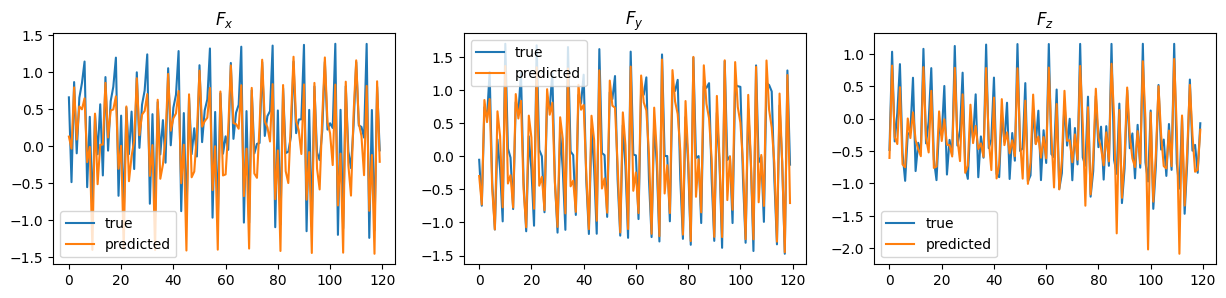

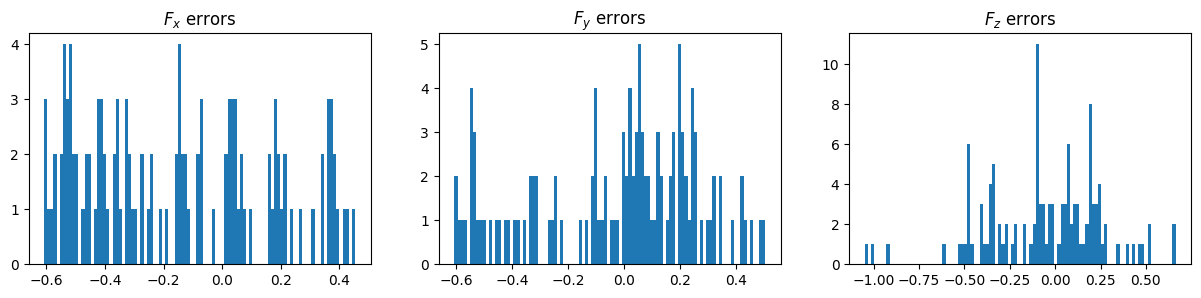

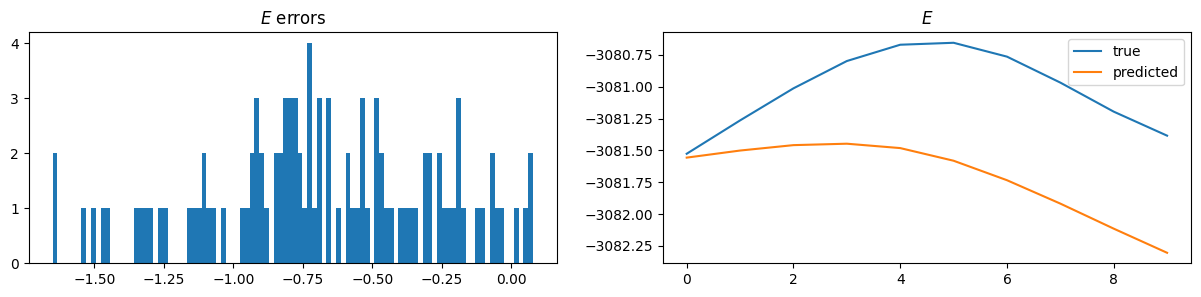

Atomic group [146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 5

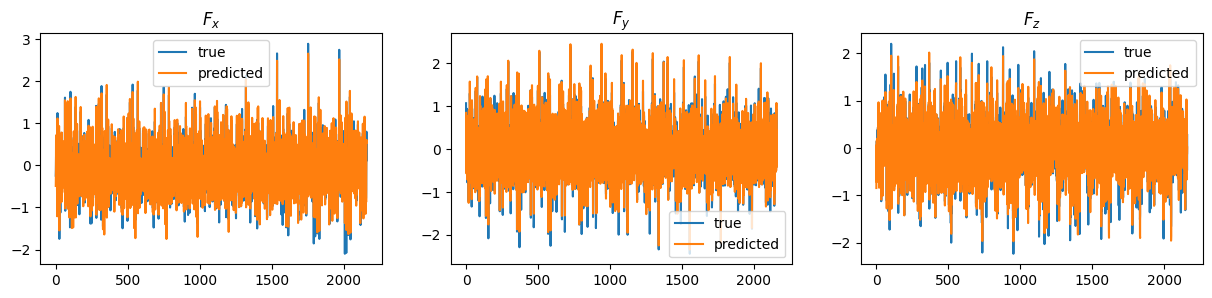

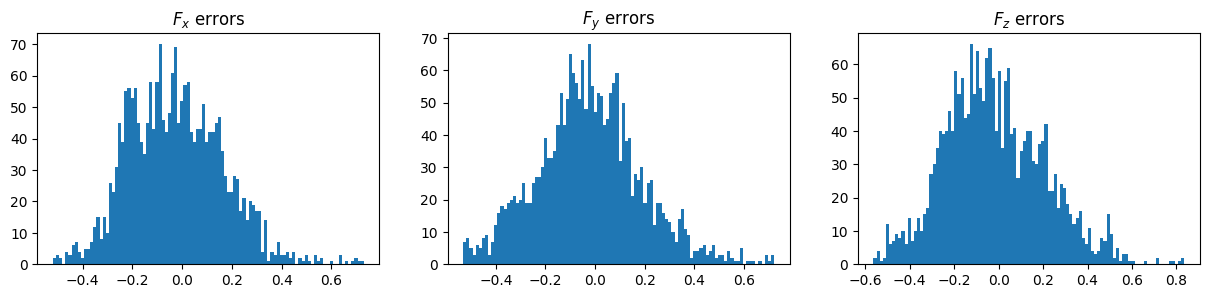

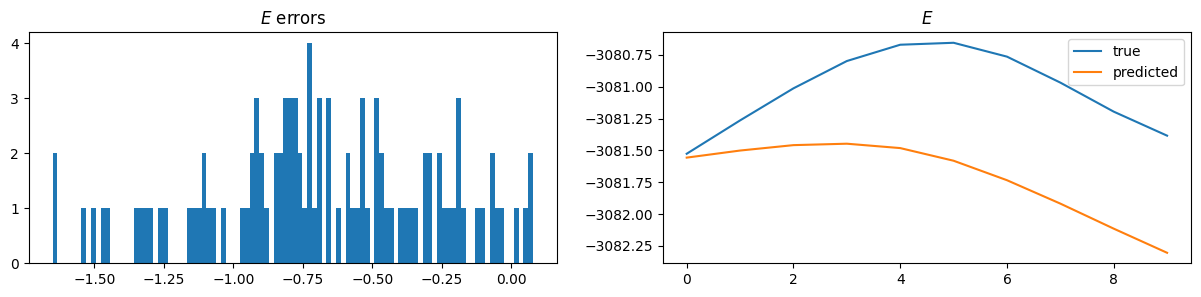

Atomic group [56, 57, 58, 59, 60, 61, 66, 67, 68, 69, 70, 71, 72, 73, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 98, 99, 100, 101, 320, 321, 322, 323, 324, 325, 330, 331, 332, 333, 334, 335, 336, 337, 340, 341, 342, 343, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 362, 363, 364, 365]
F_x
MAE 0.34337902477598703
RMSE 0.4285950746084883
F_y
MAE 0.33049501132820724
RMSE 0.4269199882495493
F_z
MAE 0.37426604512027806
RMSE 0.4772363356154667
E
MAE 0.6907855221750288
RMSE 0.7997303236080108


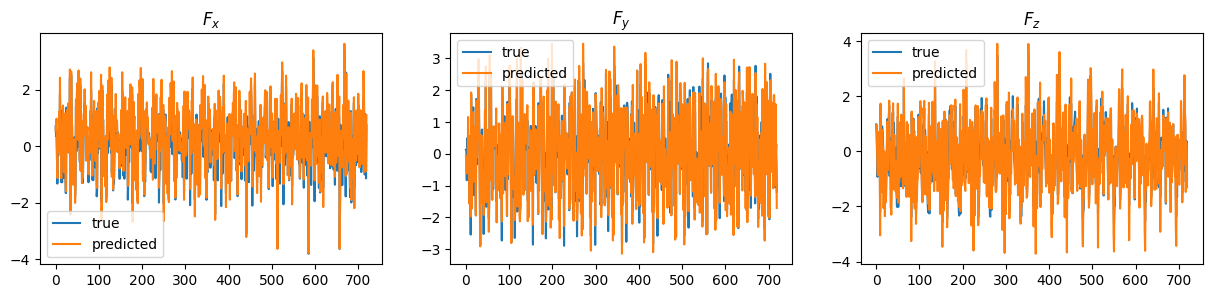

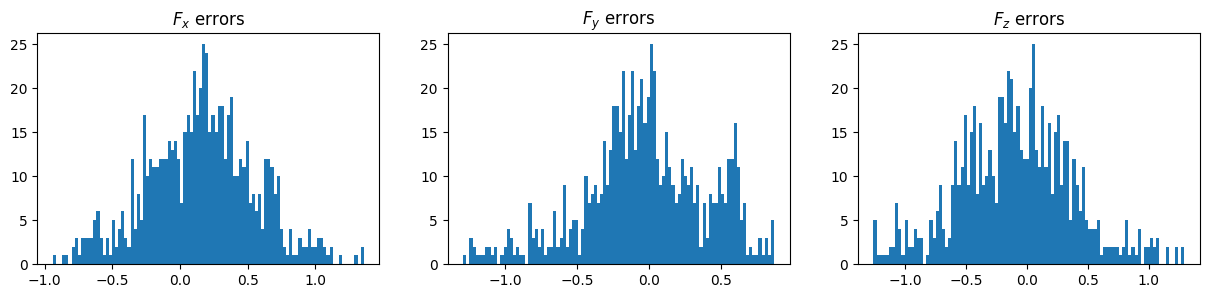

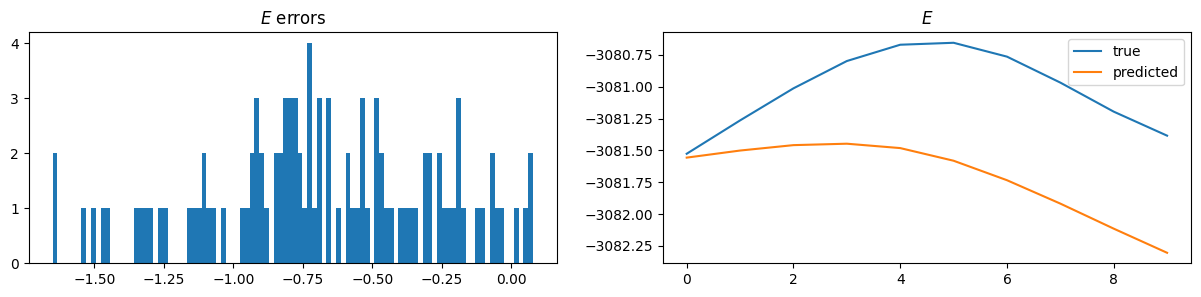

Atomic group [108, 109, 110, 111, 112, 113, 372, 373, 374, 375, 376, 377]
F_x
MAE 0.1834497890994711
RMSE 0.22664076139459227
F_y
MAE 0.19010649122411846
RMSE 0.2479585943747395
F_z
MAE 0.2603495036681203
RMSE 0.34131686477747974
E
MAE 0.6907855221750288
RMSE 0.7997303236080108


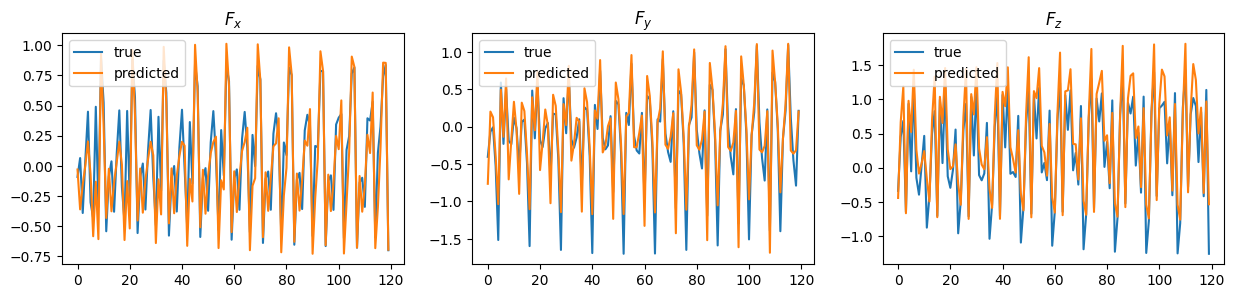

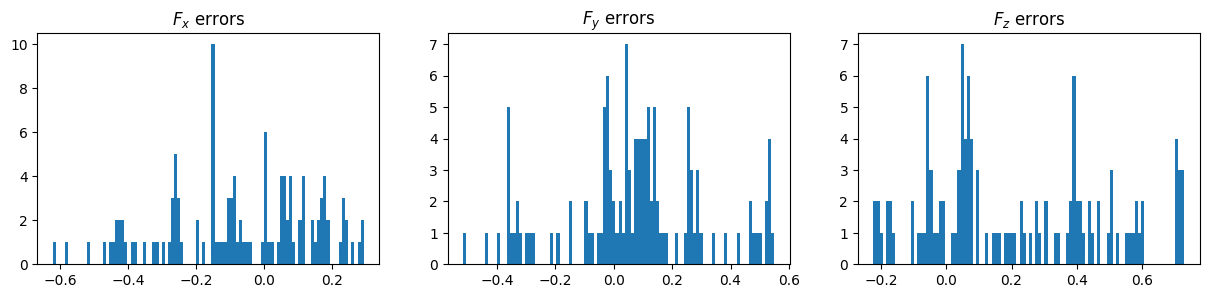

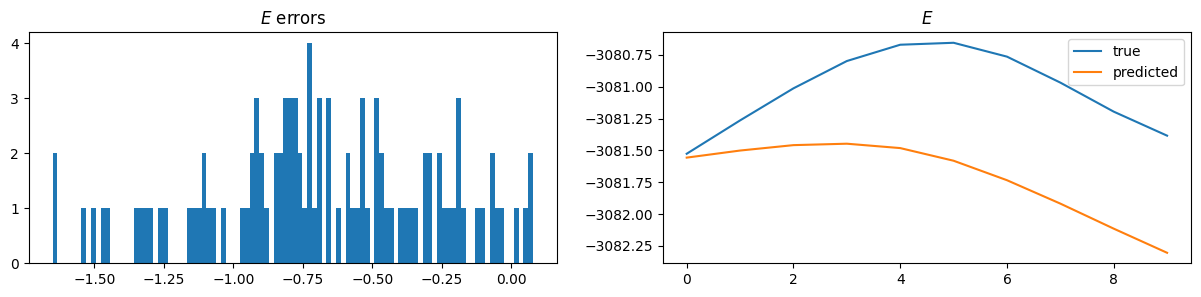

Atomic group [6, 7, 8, 9, 10, 11, 270, 271, 272, 273, 274, 275]
F_x
MAE 0.3511289991266287
RMSE 0.41728002156574906
F_y
MAE 0.3412448119091064
RMSE 0.4467763791036255
F_z
MAE 0.30732239301735026
RMSE 0.39494764080518174
E
MAE 0.6907855221750288
RMSE 0.7997303236080108


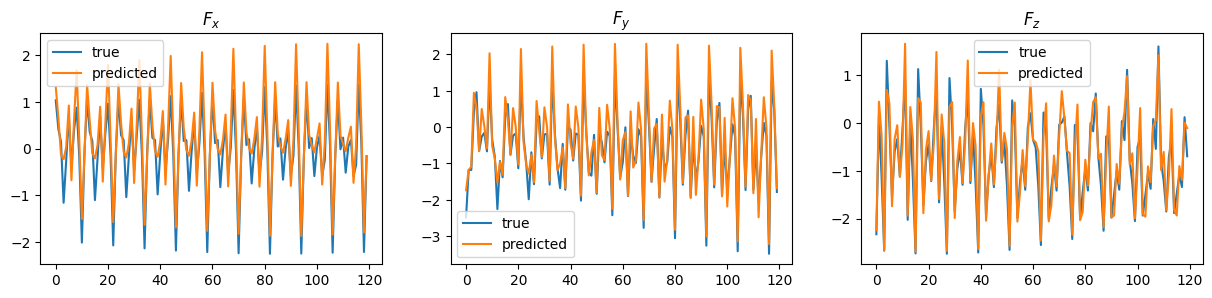

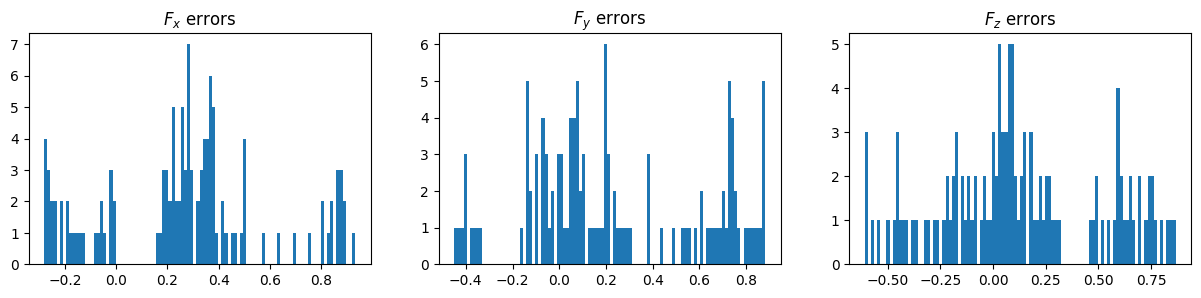

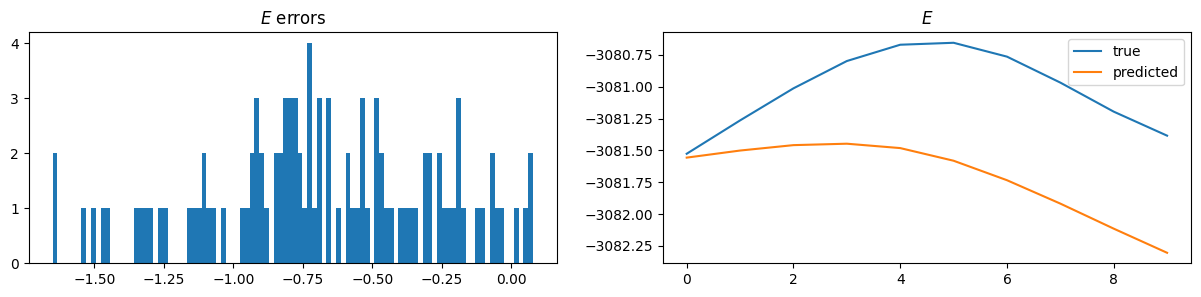

Atomic group [116, 117, 118, 119, 122, 123, 124, 125, 134, 135, 136, 137, 380, 381, 382, 383, 386, 387, 388, 389, 398, 399, 400, 401]
F_x
MAE 0.2237501617910093
RMSE 0.27826597022066285
F_y
MAE 0.1434376944529957
RMSE 0.17477973381230305
F_z
MAE 0.1415554824188003
RMSE 0.16715094617971604
E
MAE 0.6907855221750288
RMSE 0.7997303236080108


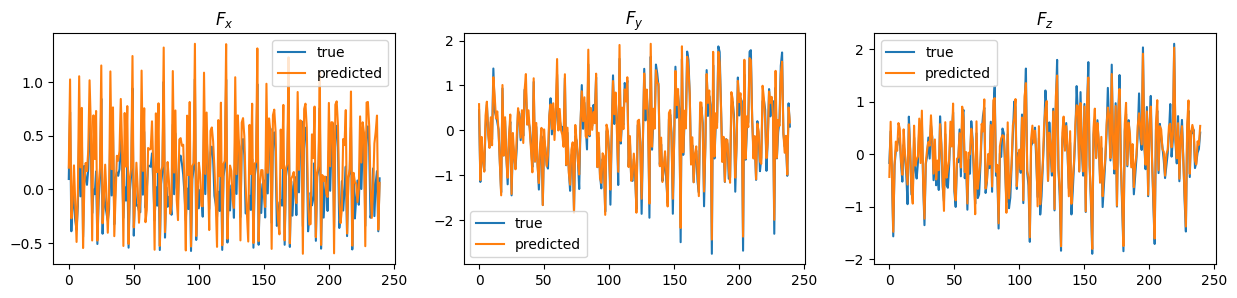

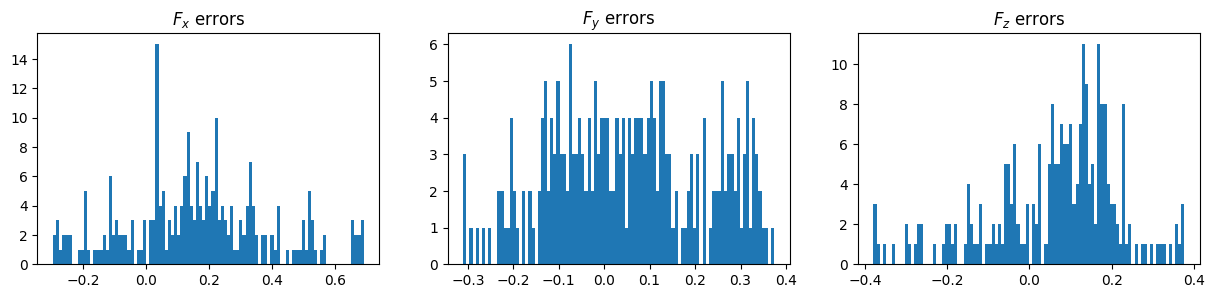

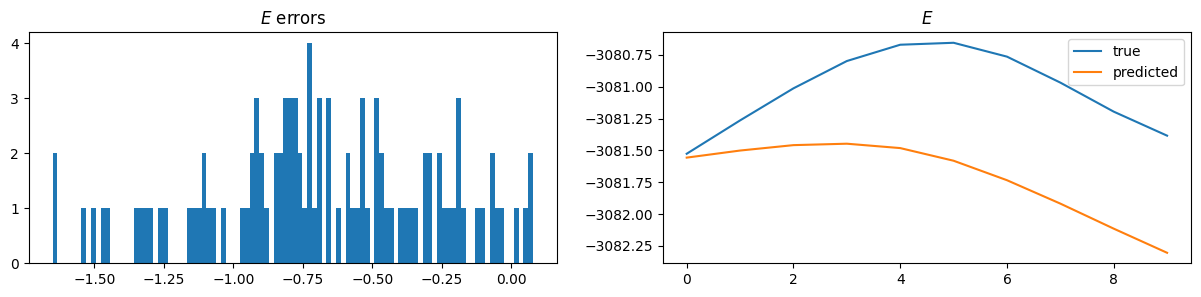

Atomic group [36, 37, 50, 51, 52, 53, 54, 55, 62, 63, 64, 65, 74, 75, 80, 81, 96, 97, 300, 301, 314, 315, 316, 317, 318, 319, 326, 327, 328, 329, 338, 339, 344, 345, 360, 361]
F_x
MAE 0.25874588139216476
RMSE 0.3374547982225372
F_y
MAE 0.22870690523371442
RMSE 0.2963480611251813
F_z
MAE 0.3037872705074305
RMSE 0.3883700180745745
E
MAE 0.6907855221750288
RMSE 0.7997303236080108


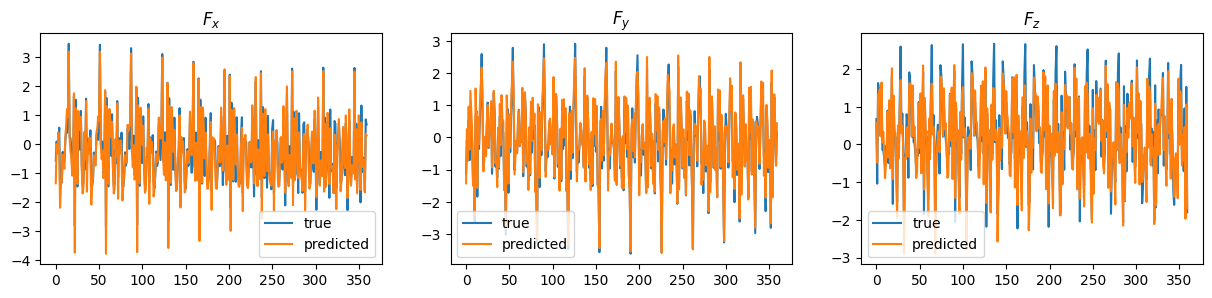

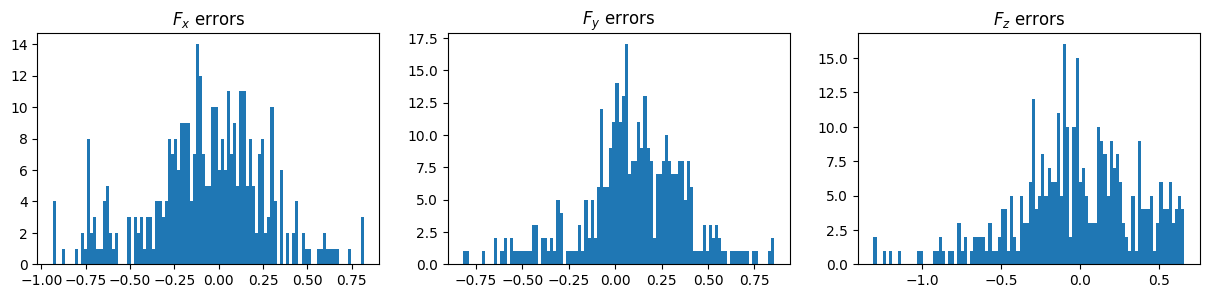

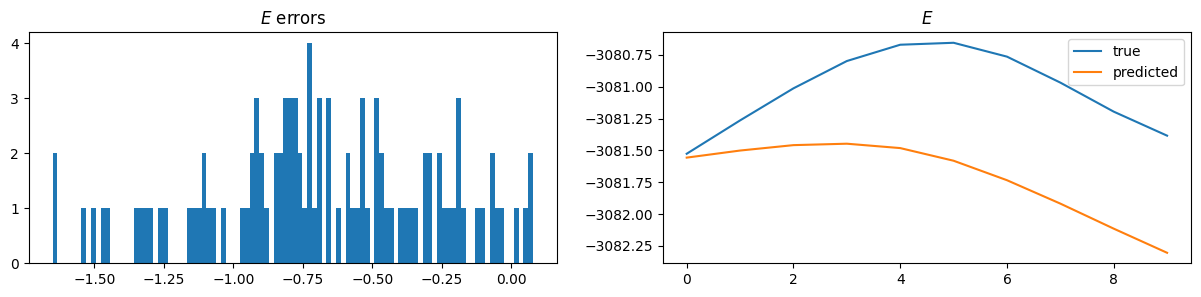

Atomic group [114, 115, 120, 121, 126, 127, 128, 129, 132, 133, 138, 139, 378, 379, 384, 385, 390, 391, 392, 393, 396, 397, 402, 403]
F_x
MAE 0.10271224273245506
RMSE 0.13135658085479526
F_y
MAE 0.12194837124032268
RMSE 0.14850881727212176
F_z
MAE 0.09948648677280705
RMSE 0.13422624321070908
E
MAE 0.6907855221750288
RMSE 0.7997303236080108


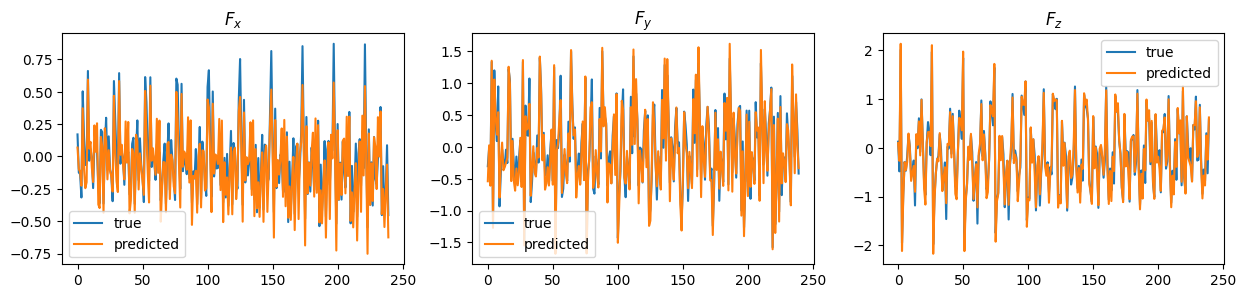

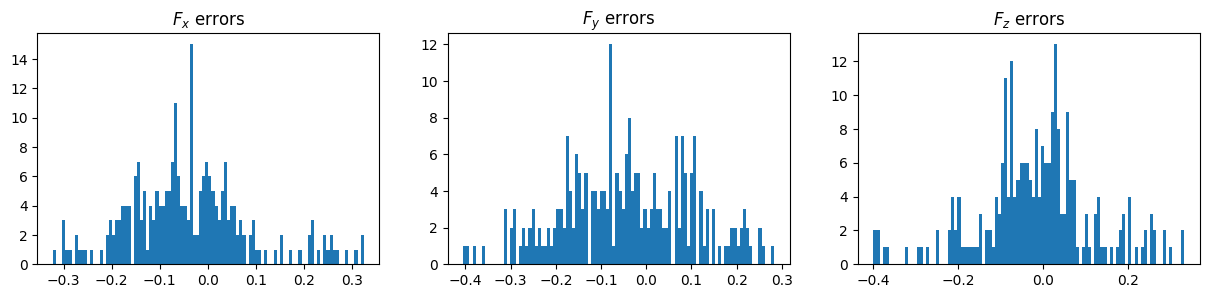

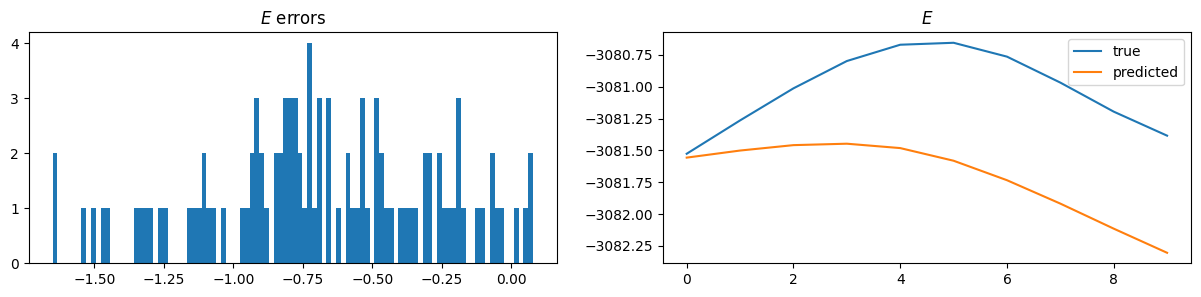

Atomic group [16, 17, 20, 21, 24, 25, 28, 29, 42, 43, 46, 47, 280, 281, 284, 285, 288, 289, 292, 293, 306, 307, 310, 311]
F_x
MAE 0.21530011635492954
RMSE 0.2708230039048458
F_y
MAE 0.42484499017480354
RMSE 0.5367442669717007
F_z
MAE 0.42469615061488253
RMSE 0.5237515292024991
E
MAE 0.6907855221750288
RMSE 0.7997303236080108


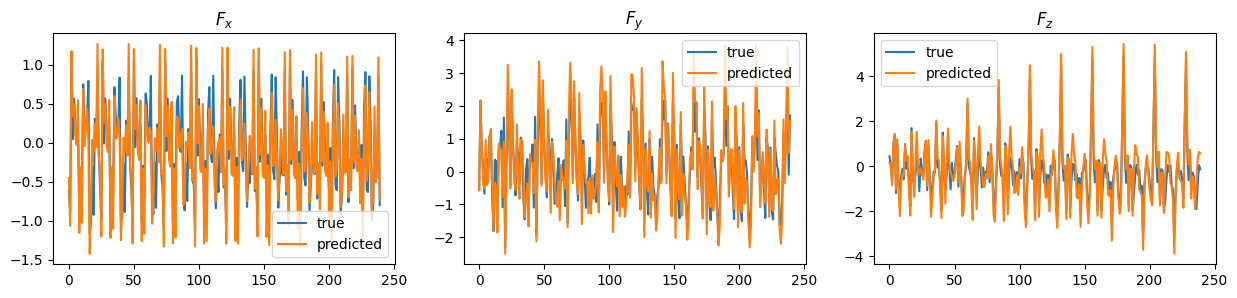

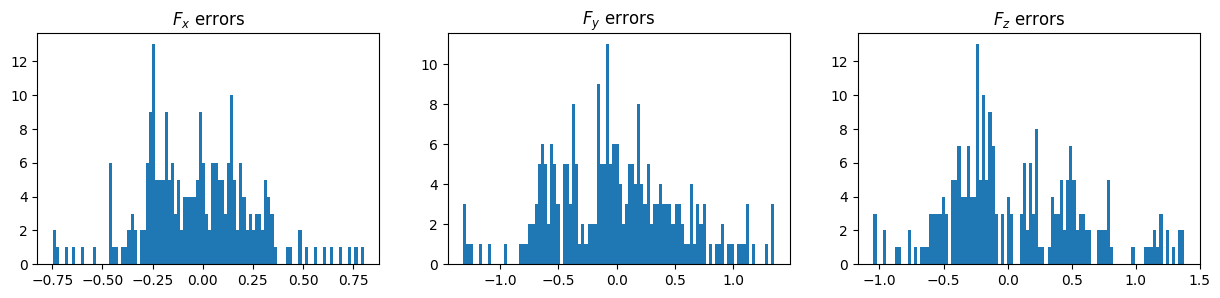

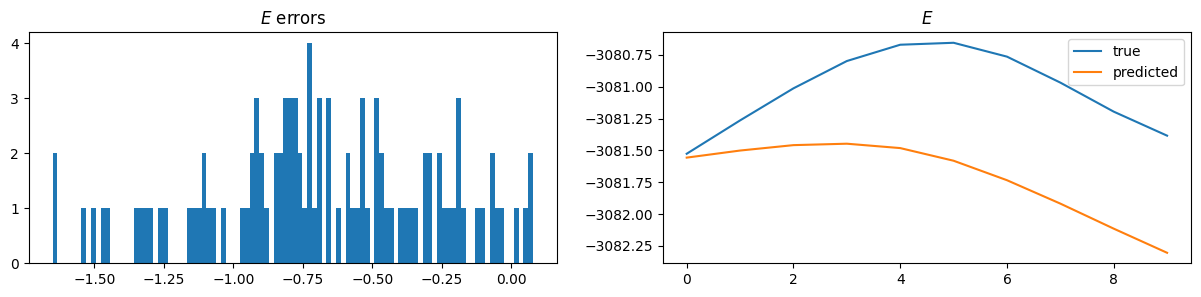

Atomic group [130, 131, 140, 141, 142, 143, 144, 145, 164, 165, 166, 167, 192, 193, 206, 207, 250, 251, 394, 395, 404, 405, 406, 407, 408, 409, 428, 429, 430, 431, 456, 457, 470, 471, 514, 515]
F_x
MAE 0.15824387887254507
RMSE 0.1920670771519837
F_y
MAE 0.15602319994224287
RMSE 0.19365522865307455
F_z
MAE 0.12792139367342353
RMSE 0.1609437503156552
E
MAE 0.6907855221750288
RMSE 0.7997303236080108


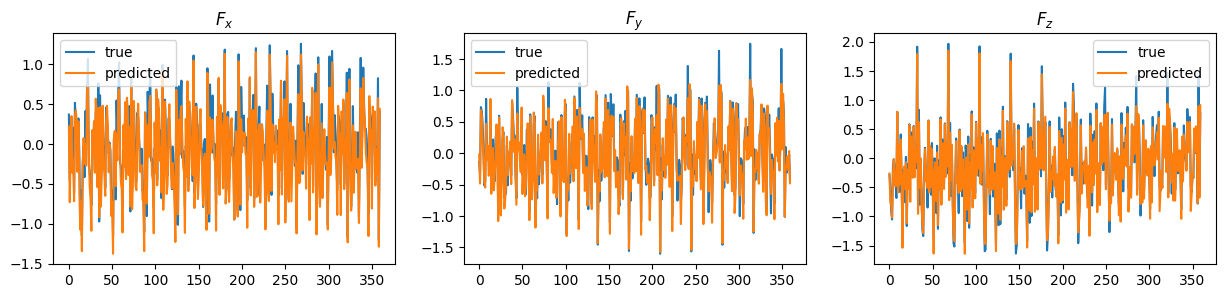

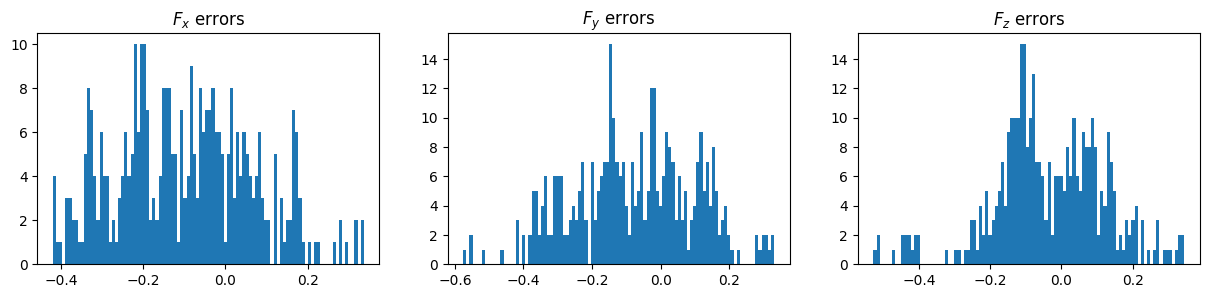

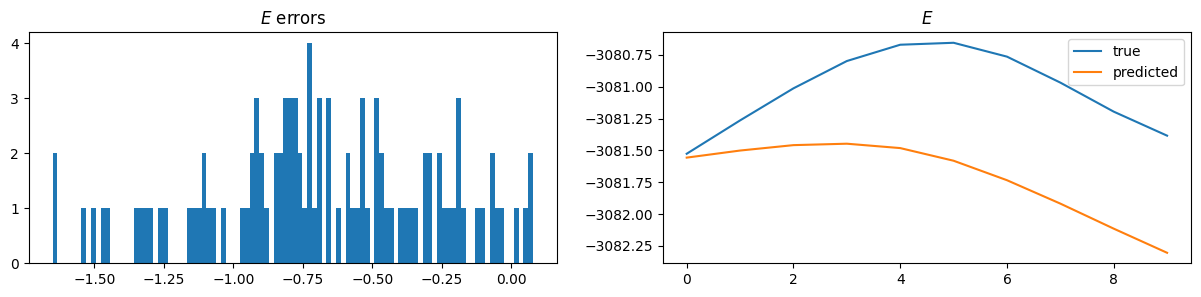

Atomic group [18, 19, 26, 27, 44, 45, 282, 283, 290, 291, 308, 309]
F_x
MAE 0.14802563867794039
RMSE 0.1736774777985883
F_y
MAE 0.1938511479025524
RMSE 0.24065584581796212
F_z
MAE 0.2170973496969731
RMSE 0.29343539480477576
E
MAE 0.6907855221750288
RMSE 0.7997303236080108


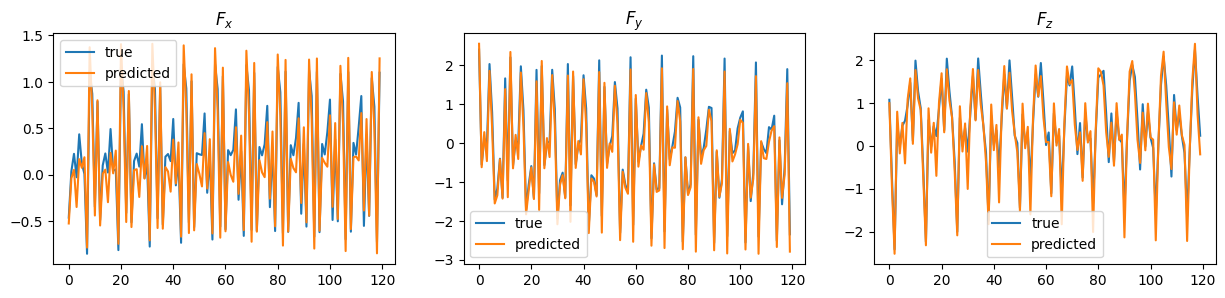

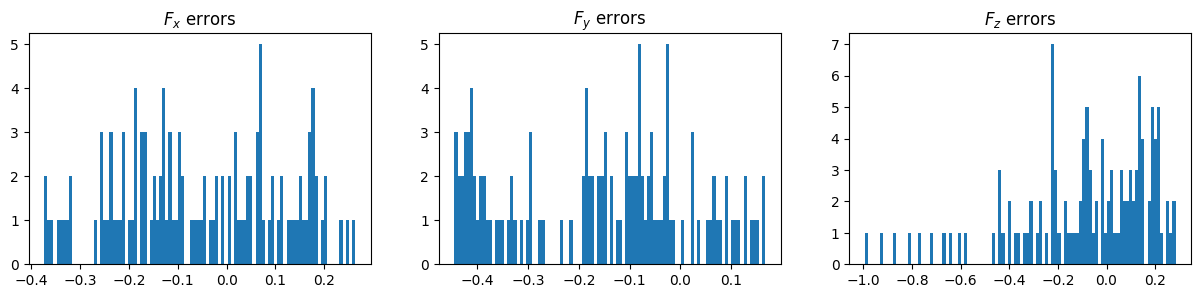

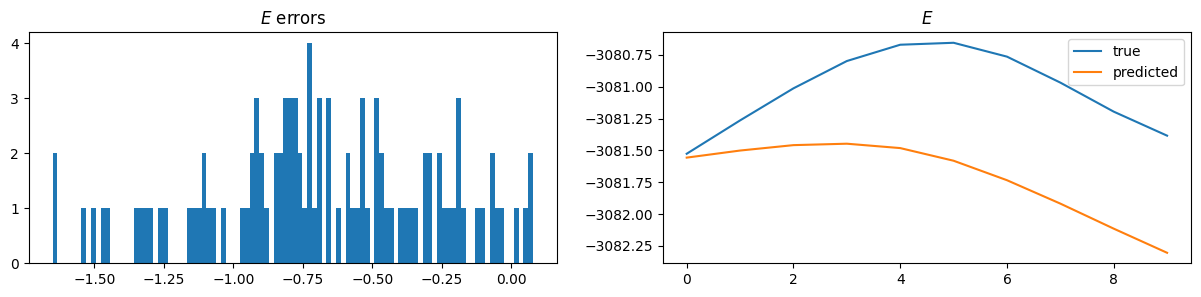

Atomic group [14, 15, 22, 23, 30, 31, 34, 35, 40, 41, 48, 49, 278, 279, 286, 287, 294, 295, 298, 299, 304, 305, 312, 313]
F_x
MAE 0.2151930130822803
RMSE 0.30305226668280255
F_y
MAE 0.38223515912638045
RMSE 0.45999330512518094
F_z
MAE 0.45425378057800536
RMSE 0.583606906957266
E
MAE 0.6907855221750288
RMSE 0.7997303236080108


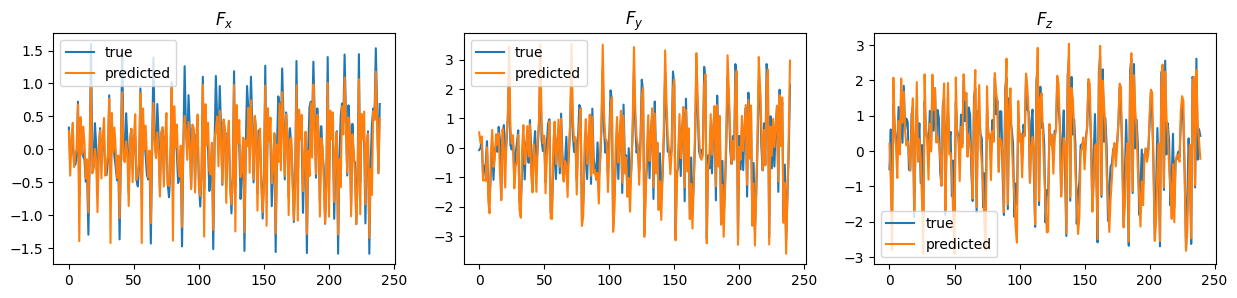

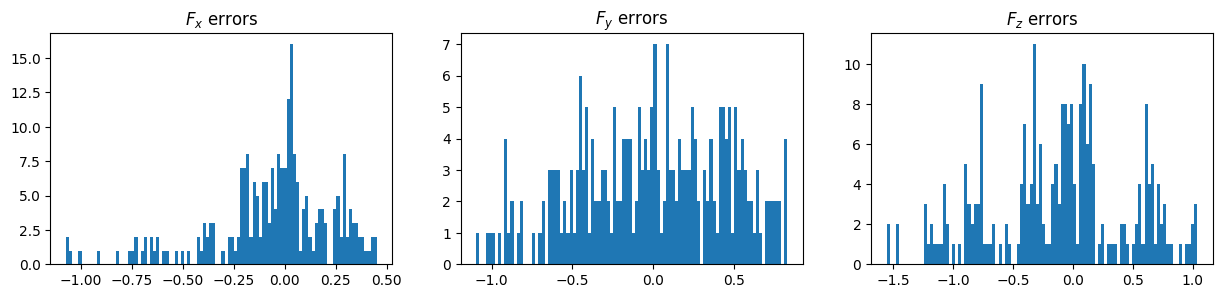

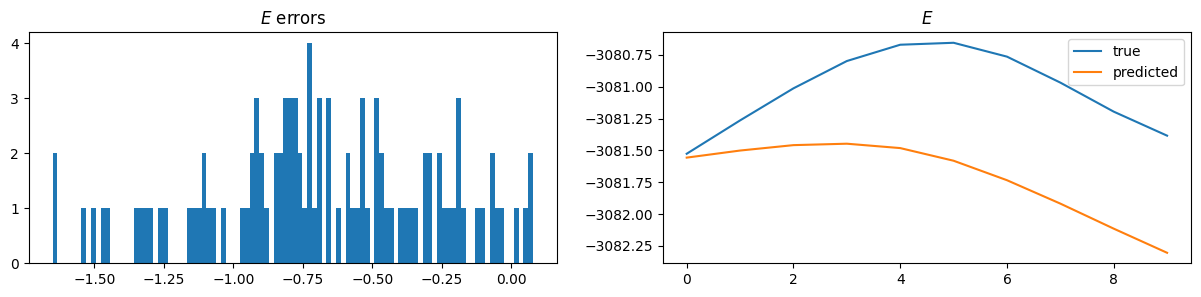

Atomic group [12, 13, 32, 33, 38, 39, 276, 277, 296, 297, 302, 303]
F_x
MAE 0.207992357134013
RMSE 0.31712293296480765
F_y
MAE 0.40999474026100907
RMSE 0.4709745183239589
F_z
MAE 0.39872855874600327
RMSE 0.5028618408434312
E
MAE 0.6907855221750288
RMSE 0.7997303236080108


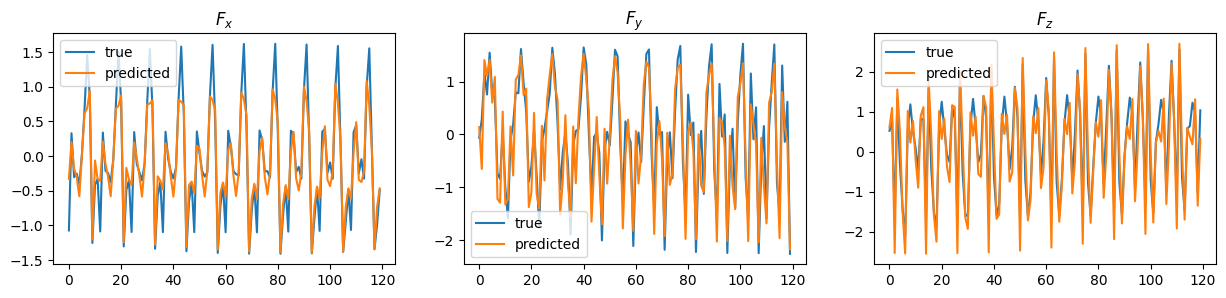

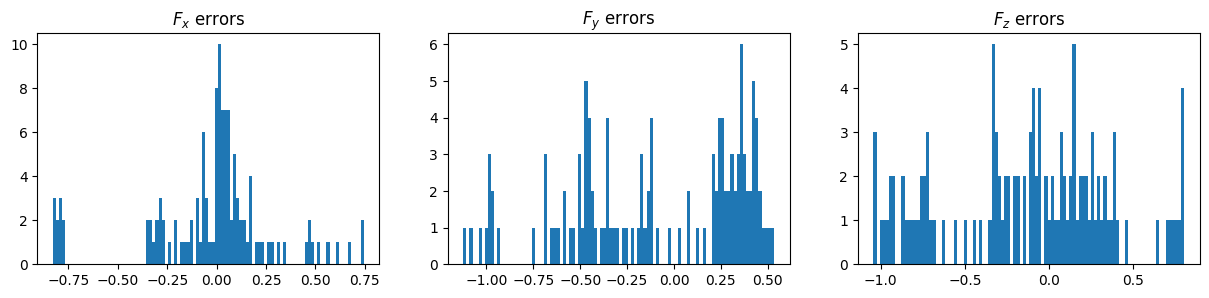

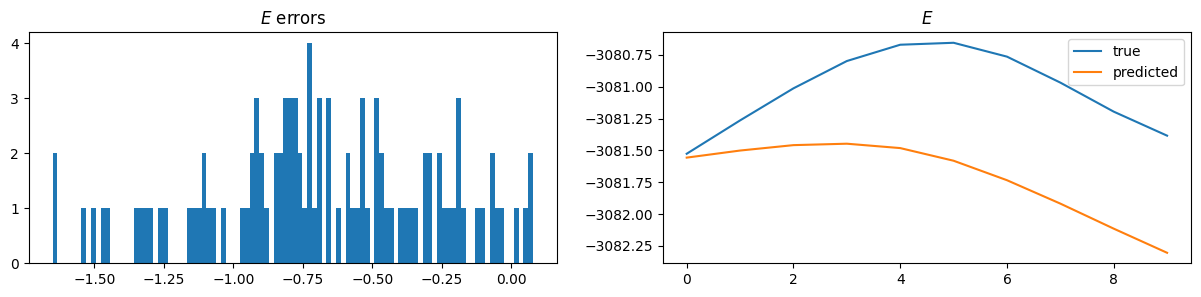

Atomic group [102, 103, 104, 105, 106, 107, 366, 367, 368, 369, 370, 371]
F_x
MAE 0.2752661465571963
RMSE 0.3214170041414508
F_y
MAE 0.46070471130342494
RMSE 0.5477373363789917
F_z
MAE 0.30658917797771895
RMSE 0.3595804742990829
E
MAE 0.6907855221750288
RMSE 0.7997303236080108


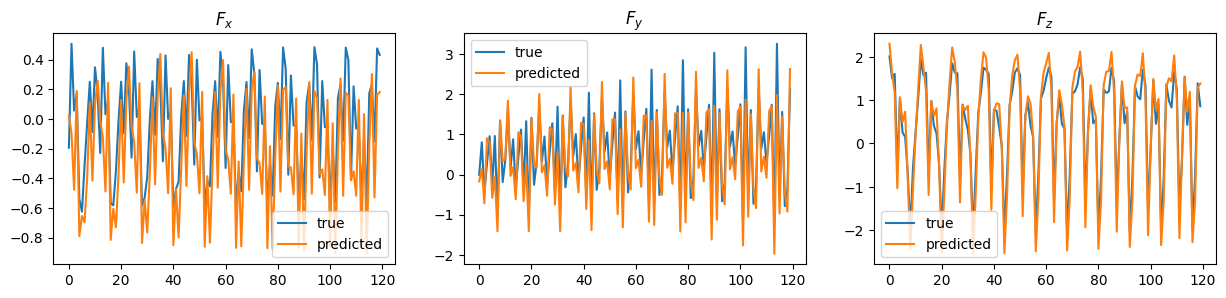

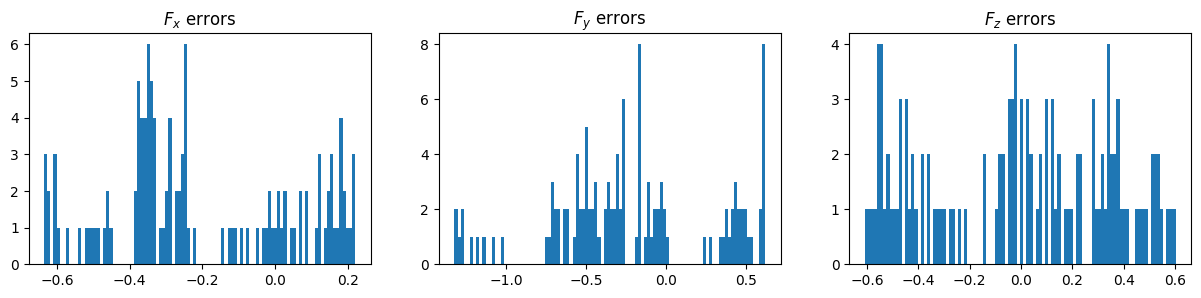

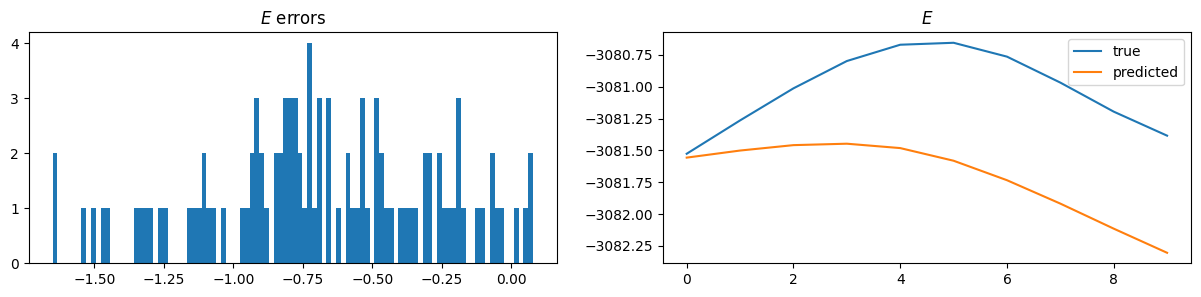

In [27]:
import numpy as np
import matplotlib.pyplot as plt

energy_true = np.array(energy_true)
energy_predicted = np.array(energy_predicted)
energy_errors = energy_predicted - energy_true

forces_true = np.array(forces_true)
forces_predicted = np.array(forces_predicted)
forces_errors = forces_predicted - forces_true

atomic_groups = predictor_loaded.fdm.atomic_groups



for ag in atomic_groups:

    print("Atomic group", ag)
    print("F_x")
    print("MAE", np.mean(np.abs(forces_errors[:, ag, 0].flatten())))
    print("RMSE", np.sqrt(np.mean(forces_errors[:, ag, 0].flatten()**2)))
    print("F_y")
    print("MAE", np.mean(np.abs(forces_errors[:, ag, 1].flatten())))
    print("RMSE", np.sqrt(np.mean(forces_errors[:, ag, 1].flatten()**2)))
    print("F_z")
    print("MAE", np.mean(np.abs(forces_errors[:, ag, 2].flatten())))
    print("RMSE", np.sqrt(np.mean(forces_errors[:, ag, 2].flatten()**2)))
    print("E")
    print("MAE", np.mean(np.abs(energy_errors.flatten())))
    print("RMSE", np.sqrt(np.mean(energy_errors.flatten()**2)))

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
    axs[0].set_title(r"$F_x$")
    axs[0].plot(np.array(forces_true)[:, ag, 0].flatten(), label="true")
    axs[0].plot(np.array(forces_predicted)[:, ag, 0].flatten(), label="predicted")
    axs[0].legend()

    axs[1].set_title(r"$F_y$")
    axs[1].plot(np.array(forces_true)[:, ag, 1].flatten(), label="true")
    axs[1].plot(np.array(forces_predicted)[:, ag, 1].flatten(), label="predicted")
    axs[1].legend()

    axs[2].set_title(r"$F_z$")
    axs[2].plot(np.array(forces_true)[:, ag, 2].flatten(), label="true")
    axs[2].plot(np.array(forces_predicted)[:, ag, 2].flatten(), label="predicted")
    axs[2].legend()

    plt.show()

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

    axs[0].set_title(r"$F_x$ errors")
    axs[0].hist(forces_errors[:, ag, 0].flatten(), bins=100)

    axs[1].set_title(r"$F_y$ errors")
    axs[1].hist(forces_errors[:, ag, 1].flatten(), bins=100)

    axs[2].set_title(r"$F_z$ errors")
    axs[2].hist(forces_errors[:, ag, 2].flatten(), bins=100)
    plt.show()

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    axs[0].set_title(r"$E$ errors")
    axs[0].hist(energy_errors.flatten(), bins=100)

    axs[1].set_title(r"$E$")
    axs[1].plot(energy_true, label="true")
    axs[1].plot(energy_predicted, label="predicted")
    axs[1].legend()
    plt.show()
